In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import warnings
from numpy import absolute
from pandas import read_csv
from sklearn import metrics
from sklearn.feature_selection import (SelectKBest, f_classif, mutual_info_classif, chi2, f_regression,
                                       mutual_info_regression,
                                       SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from xgboost import XGBRegressor, XGBClassifier

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import itertools

In [28]:
raw_data = pd.read_csv("/content/drive/MyDrive/ML_Project_Drought/train_timeseries/train_timeseries.csv")
clean_data = "/content/drive/MyDrive/cleaned_data.csv"

In [29]:
df_clean = pd.read_csv(clean_data)
df_raw = raw_data.dropna()

In [30]:
df_clean['date']= pd.to_datetime(df_clean['date'])
df_raw['date']= pd.to_datetime(df_raw['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
# converting to binary
df_binary = df_clean
df_binary['score'] = df_clean['score'].map({0:0, 1:1, 2:1, 3:1, 4:1, 5:1})

In [24]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = DataFrame()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols = concat([cols,df.shift(25)], axis=1)

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols = concat([cols,df.shift(-25)], axis=1)

    if dropnan:
        cols.dropna(inplace=True)
    # print(i, agg)
    return cols
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBClassifier(n_estimators=100)
    model.fit(trainX, trainy)
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, model_name):
    predictions = list()

    last_n = -1*n_test
    X_data = data.drop(['score41'], axis=1)
    y_data = data['score41']
    X_train = X_data.iloc[:last_n]
    y_train = y_data.iloc[:last_n]
    X_test = X_data.iloc[last_n:]
    y_test = y_data.iloc[last_n:]

    if model_name == 'XGBClassifier':
      result = XGBOOST_Classifier(X_train, y_train, X_test, y_test)
    else:
      result = XGBOOST_Regressor(X_train, y_train, X_test, y_test)

    accuracy =result['accuracy']
    precision=result['precision']
    recall=result['recall']
    fscore=result['f-score']
    mae = result['mae']
    rmse = result['rmse']

    printResults(accuracy,precision,recall,fscore,mae,rmse, model_name)
    return result

def XGBOOST_Classifier(X_train, y_train, X_test, y_test):
  # fit model no training data
    model = XGBClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # plot_df = concat([X_test['month'], X_test['year'],y_test, y_pred)
    default_x_ticks = range(100)
    plt.plot(default_x_ticks, y_test[-100:], label='Expected')
    plt.plot(default_x_ticks, y_pred[-100:], label='Predicted')
    plt.legend()
    plt.show()
    return {
            'accuracy':metrics.accuracy_score(y_test, y_pred),
            'recall': metrics.recall_score(y_pred, y_test, average='micro'),
            'precision':metrics.precision_score(y_pred, y_test, average='micro'),
            'f-score':metrics.f1_score(y_pred, y_test, average='micro'),
            'y_pred':y_pred,
            'y_test':y_test,
            'mae':metrics.mean_absolute_error(y_test, y_pred),
            'rmse':np.sqrt(metrics.mean_squared_error(y_test, y_pred)) 
          }

def printResults(acc,pre,rec,fs,mae, rmse, model_name):
    print("Results for ", model_name)
    print("Accuracy:",acc)
    print("Precision:",pre)
    print("Recall:",rec)
    print("F1-score:",fs)
    print("MAE:",mae)
    print("rmse:",rmse)

In [43]:
df_small = df_clean.sample(10000).sort_values(by=['date'])

# transform the time series data into supervised learning
df_small['year'] = pd.DatetimeIndex(df_small['date']).year
df_small['month'] = pd.DatetimeIndex(df_small['date']).month

df_small = df_small.drop(['date'], axis=1)
df_small = df_small.drop('Unnamed: 0',1)

data = series_to_supervised(df_small, n_in=1)
# Columns to not rename
excluded = data.columns[~data.columns.duplicated(keep=False)]
# An incrementer
inc = itertools.count().__next__

# A renamer
def ren(name):
  new_name = f"{name}{inc()}" if name not in excluded else name
  return new_name

# Use inside rename()
data.rename(columns=ren, inplace=True)

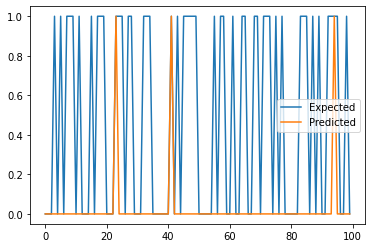

Results for  XGBClassifier
Accuracy: 0.686
Precision: 0.686
Recall: 0.686
F1-score: 0.686
MAE: 0.314
rmse: 0.5603570290448759


In [44]:
result = walk_forward_validation(data, 500, 'XGBClassifier')